<a href="https://colab.research.google.com/github/alfredocalza/Coursera_Capstone/blob/master/Capstone_Project_The_Battle_of_Neighborhoods.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Selecting the Best Possible Location for a Bilingual Child Care Venue in Chicago, IL.

### 1. Import all necessary libraries and packages:

In [3]:
!pip install folium
!pip install geopy
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import folium
from geopy.geocoders import Nominatim
import requests
from sklearn.cluster import KMeans
import math

### 2. Obtain, process and transform the data:

For this analysis Company ABC wants to target Cook and DuPage counties, which are the most densely populated counties in the Chicago greater metropolitan area.

__2.1.__ Download the the zip code lists for each county and read them into pandas dataframes. The resulting dataframes will then be merged into one single dataframe named zip_df:

In [4]:
# Download the zip codes from the internet and read the data into two separate pandas dataframes (one for each county).
url1 = 'https://www.zipcodestogo.com/Cook/IL/'
url2 = 'https://www.zipcodestogo.com/Dupage/IL/'
zip_df1 = pd.read_html(url1)[1]
zip_df2 = pd.read_html(url2)[1]
zip_df1.columns = ['Zip Code', 'City', 'State', 'Zip Code Map']
zip_df1.drop(['State', 'Zip Code Map'], axis=1, inplace=True)
zip_df1.drop([0,1], axis=0, inplace=True)
zip_df2.columns = ['Zip Code', 'City', 'State', 'Zip Code Map']
zip_df2.drop(['State', 'Zip Code Map'], axis=1, inplace=True)
zip_df2.drop([0,1], axis=0, inplace=True)

# Merge both dataframes into a single dataframe named "zip_df":
zip_df = zip_df1.merge(zip_df2, how='outer').reset_index(drop=True)
zip_df = zip_df.astype({'Zip Code':'int64'})
zip_df = zip_df.astype({'Zip Code':'str'})
print(zip_df.shape)
zip_df.head()

(276, 2)


,Zip Code,City
0,60004,Arlington Heights
1,60005,Arlington Heights
2,60006,Arlington Heights
3,60007,Elk Grove Village
4,60008,Rolling Meadows


__2.2.__ Obtain the income tax by zip code dataset from the IRS website and read the table into a pandas dataframe. The dataframe will then be processed and cleaned according to the needs of the analysis:

In [5]:
# Obtain the 2018 income tax information by zip code from the IRS and read the table into a pandas dataframe:
url = 'https://www.irs.gov/pub/irs-soi/18zpallnoagi.csv'
IRS_df = pd.read_csv(url)
IRS_df = IRS_df.astype({'ZIPCODE':'str'})
# Drop all zip codes outside Cook and Dupage counties:
IRS_df = IRS_df.merge(zip_df,left_on='ZIPCODE',right_on='Zip Code',how='right')
# Create a column with the average total number of dependents per household and another one for income per household:
IRS_df['Income per household'] = round(IRS_df['A02650']*1000/IRS_df['N1'],2)
IRS_df['Dependants per household'] = IRS_df['NUMDEP']/IRS_df['N1']
# Clean the data by selecting only the columns that will be used in the analysis and disregarding the rest:
IRS_df = IRS_df[['Zip Code','City','N1','Income per household','Dependants per household']].dropna(axis=0)
IRS_df.rename(columns={'N1':'Number of households'}, inplace=True)
IRS_df = IRS_df.astype({'Number of households':'int64'})
print(IRS_df.shape)
IRS_df.head()

(197, 5)


,Zip Code,City,Number of households,Income per household,Dependants per household
0,60004,Arlington Heights,26490,112728.65,0.587769
1,60005,Arlington Heights,15580,103211.36,0.535302
3,60007,Elk Grove Village,18480,75952.98,0.483225
4,60008,Rolling Meadows,11670,69124.76,0.608398
6,60016,Des Plaines,31820,60761.57,0.520113


__2.3.__ Obtain the latitude and longitude coordinates and areas for every zip code and append them to the IRS_df dataframe:

In [6]:
url = 'https://www2.census.gov/geo/docs/maps-data/data/gazetteer/2019_Gazetteer/2019_Gaz_zcta_national.zip'
lat_long_df = pd.read_csv(url, sep='\t',engine='python')
lat_long_df.drop(['ALAND','AWATER','AWATER_SQMI'], axis=1, inplace=True)
lat_long_df = lat_long_df.astype({'GEOID':'str'})
Chicago_df = IRS_df.merge(lat_long_df,left_on='Zip Code',right_on='GEOID',how='left')
Chicago_df.drop('GEOID', axis=1, inplace=True)
Chicago_df.rename(columns={'INTPTLAT':'Latitude','ALAND_SQMI':'Area (SQMI)',Chicago_df.columns[7]:'Longitude'}, inplace=True)
Chicago_df.dropna(axis=0, inplace=True)
print(Chicago_df.shape)
Chicago_df.head()

(197, 8)


,Zip Code,City,Number of households,Income per household,Dependants per household,Area (SQMI),Latitude,Longitude
0,60004,Arlington Heights,26490,112728.65,0.587769,11.083,42.112780,-87.979542
1,60005,Arlington Heights,15580,103211.36,0.535302,6.559,42.064490,-87.985462
2,60007,Elk Grove Village,18480,75952.98,0.483225,14.104,42.007517,-87.992860
3,60008,Rolling Meadows,11670,69124.76,0.608398,5.175,42.069786,-88.016221
4,60016,Des Plaines,31820,60761.57,0.520113,10.622,42.049573,-87.895003


### 3. View every zip code coordinate on the map:

In [7]:
map_chicago = folium.Map(location=[41.825,-87.6298], zoom_start=10)

# add markers to map
for lat, lng, ZipCode, city in zip(Chicago_df['Latitude'], Chicago_df['Longitude'], Chicago_df['Zip Code'], Chicago_df['City']):
    label = '{}, {}'.format(city, ZipCode)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_chicago)  
    
map_chicago

### 4. Use the Foursquare API to analyze the neighborhoods and segment them:

__4.1.__ Define Foursquare credentials and verison. The contents of the following cell include definitions for CLIENT_ID, CLIENT_SECRET and VERSION. The contents of this cell have been hidden:

In [8]:
# @hidden_cell
CLIENT_ID = 'NSBYKNBKZT0MG11WD4A3JHKVGZPBLKTVTNYKAAIHZWVAPBUQ'
CLIENT_SECRET = 'QQNOTRUP03JL1YXCKGXWTSWETWWNOFMSNIDYNGIFDNHUHG0B'
VERSION = '20201227'

__4.2.__ Define a function to obtain a .json file from Foursquare with the venue names and categories of all venues located within every zip code in Chicago. Please note that the magnitude of the search radius is variable and directly proportional to the magnitude of the areas of each zip code:

In [9]:
def getNearbyVenues(zipcodes, latitudes, longitudes, zipareas, const, LIMIT):
    
    venues_list=[]
    for zipcode, lat, lng, zipareas in zip(zipcodes, latitudes, longitudes, zipareas):
        
        # Need to define a variable radius because every zip code has a different area:
        radius=const*math.sqrt(zipareas/math.pi)*1610
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)

        # make the GET request
        results = requests.get(url).json()['response']['groups'][0]['items']

        # return only relevant information for each nearby venue
        venues_list.append([(
            zipcode, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Zip Code', 
                  'Zip Code Latitude', 
                  'Zip Code Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

__4.3.__ Obtain a dataframe containing all venues located within the specified zip codes by using the function defined in the previous step:

In [10]:
Chicago_venues = getNearbyVenues(Chicago_df['Zip Code'], Chicago_df['Latitude'], Chicago_df['Longitude'], Chicago_df['Area (SQMI)'], const=1.25, LIMIT=200)
print(Chicago_venues.shape)
Chicago_venues.head(10)

(15965, 7)


,Zip Code,Zip Code Latitude,Zip Code Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,60004,42.11278,-87.979542,Trader Joe's,42.113167,-87.982543,Grocery Store
1,60004,42.11278,-87.979542,Binny's Beverage Depot,42.113807,-87.984634,Liquor Store
2,60004,42.11278,-87.979542,Chipotle Mexican Grill,42.112781,-87.978320,Mexican Restaurant
3,60004,42.11278,-87.979542,Sun Shui,42.115282,-87.985345,Chinese Restaurant
4,60004,42.11278,-87.979542,Panera Bread,42.112463,-87.981708,Bakery
5,60004,42.11278,-87.979542,LA Fitness,42.107957,-87.978448,Gym
6,60004,42.11278,-87.979542,Olive Garden,42.109389,-87.974479,Italian Restaurant
7,60004,42.11278,-87.979542,Gail's Carriage Place,42.113484,-87.979423,Breakfast Spot
8,60004,42.11278,-87.979542,Smash Burger,42.114233,-87.983625,Burger Joint
9,60004,42.11278,-87.979542,Ulta Beauty - Curbside Pickup Only,42.112753,-87.981959,Cosmetics Shop


__4.4.__ Check the number of venues per zip code:

In [11]:
print(Chicago_venues[['Zip Code','Venue']].groupby('Zip Code').count().shape)
Chicago_venues[['Zip Code','Venue']].groupby('Zip Code').count()

(197, 1)


,Venue
Zip Code,
60004,100
60005,100
60007,100
60008,97
60016,100
60018,100
60022,36
60025,100
60026,96


__4.5.__ Find the number of unique venue categories:

In [12]:
print(len(Chicago_venues['Venue Category'].unique()), "unique venue categories!")

444 unique venue categories!


__4.6.__ Perform one hot encoding on venue categories:

In [13]:
# one hot encoding
Chicago_onehot = pd.get_dummies(Chicago_venues[['Venue Category']], prefix="", prefix_sep="")
# add neighborhood column back to dataframe
Chicago_onehot['Zip Code'] = Chicago_venues['Zip Code'] 
# move zip code column to the first column
fixed_columns = [Chicago_onehot.columns[-1]] + list(Chicago_onehot.columns[:-1])
Chicago_onehot = Chicago_onehot[fixed_columns]

print(Chicago_onehot.shape)
Chicago_onehot.head()

(15965, 445)


,Zip Code,ATM,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Amphitheater,Animal Shelter,Antique Shop,Aquarium,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Assisted Living,Athletics & Sports,Auto Dealership,Auto Garage,Automotive Shop,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Bavarian Restaurant,Beach,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Bowling Alley,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Buffet,Building,Bulgarian Restaurant,Burger Joint,Burmese Restaurant,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Camera Store,Campground,Candy Store,Cantonese Restaurant,Car Wash,Caribbean Restaurant,Casino,Cemetery,Chaat Place,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Circus,City,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Administrative Building,College Arts Building,College Gym,College Quad,College Theater,Comedy Club,Comfort Food Restaurant,Comic Shop,Community Center,Community College,Concert Hall,Construction & Landscaping,Convenience Store,Convention Center,Cosmetics Shop,Coworking Space,Creperie,Cruise Ship,Cuban Restaurant,Cultural Center,Cupcake Shop,Currency Exchange,Cycle Studio,Dance Studio,Daycare,Deli / Bodega,Dentist's Office,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Disc Golf,Discount Store,Distillery,Dive Bar,Dog Run,Donut Shop,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Elementary School,Empanada Restaurant,Escape Room,Ethiopian Restaurant,Event Service,Event Space,Exhibit,Eye Doctor,Fabric Shop,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Financial or Legal Service,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Fondue Restaurant,Food,Food & Drink Shop,Food Court,Food Service,Food Truck,Football Stadium,Forest,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Gluten-free Restaurant,Go Kart Track,Golf Course,Golf Driving Range,Gourmet Shop,Greek Restaurant,Grocery Store,Gun Range,Gun Shop,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Halal Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Heliport,High School,Hill,Historic Site,History Museum,Hobby Shop,Hockey Arena,Hockey Rink,Home Service,Hookah Bar,Hospital,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotel Pool,IT Services,Ice Cream Shop,Indian Chinese Restaurant,Indian Restaurant,Indie Movie Theater,Indie Theater,Indoor Play Area,Insurance Office,Intersection,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Karaoke Bar,Kids Store,Kitchen Supply Store,Korean Restaurant,Lake,Latin American Restaurant,Laundromat,Laundry Service,Leather Goods Store,Library,Light Rail Station,Lighthouse,Lingerie Store,Liquor Store,Locksmith,Lounge,Malay Restaurant,Marijuana Dispensary,Market,Martial Arts School,Massage Studio,Mattress Store,Medical Center,Medical Supply Store,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Military Base,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern Greek Restaurant,Molecular Gastronomy Restaurant,Moroccan Restaurant,Motel,Motorcycle Shop,Movie Theater,Moving Target,Multiplex,Museum,Music School,Music Store,Music Venue,Nail Salon,National Park,Nature Preserve,Neighborhood,New American Restaurant,Newssta

__4.7.__ Group all postal codes and calculate the number of venues for each category:

In [14]:
Chicago_grouped = Chicago_onehot.groupby('Zip Code').sum().reset_index()
print(Chicago_grouped.shape)
Chicago_grouped.head()

(197, 445)


,Zip Code,ATM,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Amphitheater,Animal Shelter,Antique Shop,Aquarium,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Assisted Living,Athletics & Sports,Auto Dealership,Auto Garage,Automotive Shop,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Bavarian Restaurant,Beach,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Bowling Alley,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Buffet,Building,Bulgarian Restaurant,Burger Joint,Burmese Restaurant,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Camera Store,Campground,Candy Store,Cantonese Restaurant,Car Wash,Caribbean Restaurant,Casino,Cemetery,Chaat Place,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Circus,City,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Administrative Building,College Arts Building,College Gym,College Quad,College Theater,Comedy Club,Comfort Food Restaurant,Comic Shop,Community Center,Community College,Concert Hall,Construction & Landscaping,Convenience Store,Convention Center,Cosmetics Shop,Coworking Space,Creperie,Cruise Ship,Cuban Restaurant,Cultural Center,Cupcake Shop,Currency Exchange,Cycle Studio,Dance Studio,Daycare,Deli / Bodega,Dentist's Office,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Disc Golf,Discount Store,Distillery,Dive Bar,Dog Run,Donut Shop,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Elementary School,Empanada Restaurant,Escape Room,Ethiopian Restaurant,Event Service,Event Space,Exhibit,Eye Doctor,Fabric Shop,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Financial or Legal Service,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Fondue Restaurant,Food,Food & Drink Shop,Food Court,Food Service,Food Truck,Football Stadium,Forest,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Gluten-free Restaurant,Go Kart Track,Golf Course,Golf Driving Range,Gourmet Shop,Greek Restaurant,Grocery Store,Gun Range,Gun Shop,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Halal Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Heliport,High School,Hill,Historic Site,History Museum,Hobby Shop,Hockey Arena,Hockey Rink,Home Service,Hookah Bar,Hospital,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotel Pool,IT Services,Ice Cream Shop,Indian Chinese Restaurant,Indian Restaurant,Indie Movie Theater,Indie Theater,Indoor Play Area,Insurance Office,Intersection,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Karaoke Bar,Kids Store,Kitchen Supply Store,Korean Restaurant,Lake,Latin American Restaurant,Laundromat,Laundry Service,Leather Goods Store,Library,Light Rail Station,Lighthouse,Lingerie Store,Liquor Store,Locksmith,Lounge,Malay Restaurant,Marijuana Dispensary,Market,Martial Arts School,Massage Studio,Mattress Store,Medical Center,Medical Supply Store,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Military Base,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern Greek Restaurant,Molecular Gastronomy Restaurant,Moroccan Restaurant,Motel,Motorcycle Shop,Movie Theater,Moving Target,Multiplex,Museum,Music School,Music Store,Music Venue,Nail Salon,National Park,Nature Preserve,Neighborhood,New American Restaurant,Newssta

__4.8.__ Identify any zip codes with daycares:

In [15]:
Chicago_venues[Chicago_venues['Venue Category'].str.contains('|'.join(['care','child','kinder','nursery']), case=False)]

,Zip Code,Zip Code Latitude,Zip Code Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
14357,60189,41.840632,-88.122024,Kid's Town,41.830298,-88.08983,Daycare


### 5. Obtain additional data regarding childcare venues in the city of Chicago:

Since there are not enough child daycare venues available in Foursquare, I will use the following State of Illinois website: https://sunshine.dcfs.illinois.gov/Content/Licensing/Daycare/ProviderLookup.aspx to obtain relevant information about all child care centers currently available in the state of Illinois.<br>
<br>
I have downloaded all relevant information available from the website and uploaded it to my Github repository as a .csv file. I will link this notebook to my github repository and read the .csv file into a pandas dataframe.<br>
<br>
__5.1.__ Obtain a complete list of all child daycare venues that currently exist in Chicago:

In [16]:
url = 'https://github.com/alfredocalza/Coursera_Capstone/raw/master/Daycare%20Providers%20IL.csv'
daycare_df = pd.read_csv(url)

__5.2.__ Process, clean and transform the data:

In [17]:
# Define variables that will later be used in filtering, processing and transforming the data: 
ZipCodes = Chicago_df['Zip Code']
spanish = ['Spanish','SPANISH','spanish']
status = ['License issued (IL)','Pending renewal application (RN)','Permit issued (IP)']
# Narrow down the results by excluding all inactive licences and by excluding all zip codes outside the area of interest:
daycare_df = daycare_df[daycare_df.Status.isin(status)]
daycare_df = daycare_df.astype({'Zip':'str'})
daycare_df = daycare_df[daycare_df.Zip.isin(ZipCodes)]
# "DCC" refers to daycare centers. I will only focus on these and disregard individual personal licenses:
daycare_df = daycare_df[daycare_df['FacilityType']=='DCC'].reset_index(drop=True)
# Replace NaN with zeros:
daycare_df.fillna(0, inplace=True)
# Add additional necessary columns:
daycare_df['BilingualCount'] = daycare_df.Languages.isin(spanish) | daycare_df.Language1.isin(spanish) | daycare_df.Language2.isin(spanish) | daycare_df.Language3.isin(spanish)
daycare_df['BilingualCount'].replace({False:0,True:1},inplace=True)
daycare_df['BilingualCapacity'] = daycare_df['BilingualCount']*daycare_df['DayCapacity']
# Group by zip code and drop unecessary columns:
daycare_df = daycare_df.groupby('Zip').agg({'ProviderID':'count','BilingualCount':'sum','DayCapacity':'sum','BilingualCapacity':'sum'}).reset_index()
daycare_df.rename(columns={'ProviderID':'TotalCount','DayCapacity':'TotalCapacity'},inplace=True)
# Print an explanation of the resulting dataframe:
print('There are currently',sum(daycare_df.TotalCount),'active child daycare venues in Cook and DuPage counties, of which',sum(daycare_df.BilingualCount),
      'are bilingual (English-Spanish).')
print('The total child capacity is',sum(daycare_df['TotalCapacity']),'children and total bilingual capacity is',sum(daycare_df['BilingualCapacity']),'children.')
print('The dimensions of daycare_df are:',daycare_df.shape)
daycare_df.head()

There are currently 1619 active child daycare venues in Cook and DuPage counties, of which 94 are bilingual (English-Spanish).
The total child capacity is 130008 children and total bilingual capacity is 9576 children.
The dimensions of daycare_df are: (186, 5)


,Zip,TotalCount,BilingualCount,TotalCapacity,BilingualCapacity
0,60004,14,0,1475,0
1,60005,5,0,372,0
2,60007,2,0,160,0
3,60008,1,0,90,0
4,60016,11,0,864,0


### 6. Create a multiple linear regression machine learning model to find the correlation between venue categories and the existence of a child daycare center in each zip code:

__6.1.__ Merge childcare venue information from the daycare_df dataframe into the Chicago_grouped dataframe: 

In [18]:
Chicago_daycare = Chicago_grouped.merge(daycare_df[['Zip','TotalCount','BilingualCount']],left_on='Zip Code',right_on='Zip',how='left').reset_index(drop=True)
Chicago_daycare.drop('Zip',axis=1,inplace=True)
Chicago_daycare.fillna(0, inplace=True)
print(Chicago_daycare.shape)
Chicago_daycare.head()

(197, 447)


,Zip Code,ATM,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Amphitheater,Animal Shelter,Antique Shop,Aquarium,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Assisted Living,Athletics & Sports,Auto Dealership,Auto Garage,Automotive Shop,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Bavarian Restaurant,Beach,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Bowling Alley,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Buffet,Building,Bulgarian Restaurant,Burger Joint,Burmese Restaurant,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Camera Store,Campground,Candy Store,Cantonese Restaurant,Car Wash,Caribbean Restaurant,Casino,Cemetery,Chaat Place,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Circus,City,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Administrative Building,College Arts Building,College Gym,College Quad,College Theater,Comedy Club,Comfort Food Restaurant,Comic Shop,Community Center,Community College,Concert Hall,Construction & Landscaping,Convenience Store,Convention Center,Cosmetics Shop,Coworking Space,Creperie,Cruise Ship,Cuban Restaurant,Cultural Center,Cupcake Shop,Currency Exchange,Cycle Studio,Dance Studio,Daycare,Deli / Bodega,Dentist's Office,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Disc Golf,Discount Store,Distillery,Dive Bar,Dog Run,Donut Shop,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Elementary School,Empanada Restaurant,Escape Room,Ethiopian Restaurant,Event Service,Event Space,Exhibit,Eye Doctor,Fabric Shop,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Financial or Legal Service,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Fondue Restaurant,Food,Food & Drink Shop,Food Court,Food Service,Food Truck,Football Stadium,Forest,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Gluten-free Restaurant,Go Kart Track,Golf Course,Golf Driving Range,Gourmet Shop,Greek Restaurant,Grocery Store,Gun Range,Gun Shop,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Halal Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Heliport,High School,Hill,Historic Site,History Museum,Hobby Shop,Hockey Arena,Hockey Rink,Home Service,Hookah Bar,Hospital,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotel Pool,IT Services,Ice Cream Shop,Indian Chinese Restaurant,Indian Restaurant,Indie Movie Theater,Indie Theater,Indoor Play Area,Insurance Office,Intersection,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Karaoke Bar,Kids Store,Kitchen Supply Store,Korean Restaurant,Lake,Latin American Restaurant,Laundromat,Laundry Service,Leather Goods Store,Library,Light Rail Station,Lighthouse,Lingerie Store,Liquor Store,Locksmith,Lounge,Malay Restaurant,Marijuana Dispensary,Market,Martial Arts School,Massage Studio,Mattress Store,Medical Center,Medical Supply Store,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Military Base,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern Greek Restaurant,Molecular Gastronomy Restaurant,Moroccan Restaurant,Motel,Motorcycle Shop,Movie Theater,Moving Target,Multiplex,Museum,Music School,Music Store,Music Venue,Nail Salon,National Park,Nature Preserve,Neighborhood,New American Restaurant,Newssta

__6.2.__ Define simple linear regression models between each venue category and the number of bilingual child care venues available in each zip code to identify the venue categories that are more strongly correlated with bilingual child care venues:

In [19]:
from sklearn import linear_model
from sklearn.metrics import r2_score
list1 = []
list2 = []
list3 = []
regr = linear_model.LinearRegression()
for column in Chicago_grouped.columns:
  if column == 'Zip Code':
    continue
  list1.append(column)
  X = np.asanyarray(Chicago_daycare[[column]])
  y = np.asanyarray(Chicago_daycare[['BilingualCount']])
  z = np.asanyarray(Chicago_daycare[['TotalCount']])
  regr.fit(X,y)
  yhat=regr.predict(X)
  list2.append(r2_score(y,yhat))
  regr.fit(X,z)
  zhat=regr.predict(X)
  list3.append(r2_score(z,zhat))
D = {'VenueCategory':list1,'r2BilingualCount':list2,'r2TotalCount':list3}
R2_df = pd.DataFrame(D)

print(R2_df.shape)
R2_df.head()

(444, 3)


,VenueCategory,r2BilingualCount,r2TotalCount
0,ATM,0.000278,0.018395
1,Accessories Store,0.000544,0.005594
2,Adult Boutique,0.000659,0.002603
3,Afghan Restaurant,0.000315,0.010833
4,African Restaurant,0.001670,0.048001


__6.3.__ Find the top 20 venue categories that are most strongly correlated with bilingual (English-Spanish) child care venues:

In [42]:
R2_bilingual = R2_df.sort_values(by='r2BilingualCount',axis=0,ascending=False).head(20).reset_index(drop=True)
R2_bilingual = R2_bilingual[['VenueCategory','r2BilingualCount']]
R2_bilingual

,VenueCategory,r2BilingualCount
0,Mexican Restaurant,0.297892
1,Taco Place,0.216447
2,Rock Club,0.206948
3,Latin American Restaurant,0.202632
4,Cocktail Bar,0.167925
5,Dessert Shop,0.160914
6,Heliport,0.146841
7,Speakeasy,0.123189
8,Ukrainian Restaurant,0.095090
9,Café,0.094379


Among the top five venues that are most strongly correlated with bilingual child care venues are Latin American and Mexican restaurants. We can predict that a good part of the hispanic and latino population could live in the areas where these venues are located.

__6.4.__ Determine the optimal number of independent variables (top venue categories) to include in the multiple linear regression model. Too few variables could underfit the model, while too many variables could overfit it:

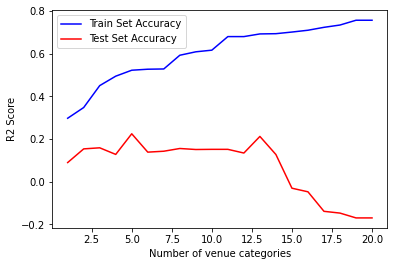

In [55]:
from sklearn.model_selection import train_test_split
in_sample_r2 = []
out_sample_r2 = []
regr2 = linear_model.LinearRegression()

for I in range(1,21):
   optimal_cat = R2_bilingual.head(I)
   X2 = np.asanyarray(Chicago_daycare[optimal_cat['VenueCategory']])
   y2 = np.asanyarray(Chicago_daycare[['BilingualCount']])
   # multiple out-of-sample evaluation:
   X_train, X_test, y_train, y_test = train_test_split( X2, y2, test_size=0.1, random_state=12)
   regr2.fit(X_train,y_train)
   out_sample_r2.append(r2_score(y_test,regr2.predict(X_test)))
   # multiple in-sample evaluation:
   regr2.fit(X2,y2)
   in_sample_r2.append(r2_score(y2,regr2.predict(X2)))

# generate the line charts to evaluate different accuracies with different number of independent variables:
plt.plot(range(1,21),in_sample_r2,'b')
plt.plot(range(1,21),out_sample_r2,'r')
plt.ylabel('R2 Score')
plt.xlabel('Number of venue categories')
plt.legend(('Train Set Accuracy', 'Test Set Accuracy'))

It looks like 13 is the optimal number of venue categories to include in our multiple linear regression model before the test set accuracy starts to drop down.

__6.4.__ Build a multiple linear regression model to predict the best location for a bilingual (English-Spanish) child daycare center based on the optimal nuber of categories of nearby venues:

In [56]:
from sklearn.model_selection import train_test_split
#Include only the optimal number of categories in the model:
R2_bilingual = R2_bilingual.head(13)
# Define the model and variables:
regr2 = linear_model.LinearRegression()
X2 = np.asanyarray(Chicago_daycare[R2_bilingual['VenueCategory']])
y2 = np.asanyarray(Chicago_daycare[['BilingualCount']])
# Check the out-of-sample accuracy of the model:
X_train, X_test, y_train, y_test = train_test_split( X2, y2, test_size=0.1, random_state=12)
regr2.fit(X_train,y_train)
print("The out of sample r2 of the model is:",r2_score(y_test,regr2.predict(X_test)))
# Re-train the model with the entire dataset:
regr2.fit(X2,y2)
# Check the in-sample accuracy of the model:
print()
print("The in-sample r2 of the model is:",r2_score(y2,regr2.predict(X2)))
# Print the coefficients
print()
print('Coefficients: ', regr2.coef_)

The out of sample r2 of the model is: 0.212630476509591

The in-sample r2 of the model is: 0.6930888002053935

Coefficients:  [[0.14304783 0.24191043 1.40137224 0.49871489 0.27908    0.20110461
  0.89105944 3.38732755 0.64494008 0.11057289 4.51966422 0.00986169
  0.3788515 ]]


__6.5.__ Use the previously-created multiple linear regression model to predict the number of bilingual child care venues per zip code. The higher the number, the stronger the correlation between nearby venues and bilingual child care locations:

In [119]:
Predicted_locations = pd.DataFrame(Chicago_daycare['Zip Code'].values,columns=['ZipCode'])
Predicted_locations[['BilingualPredicted']] = regr2.predict(X2)
Predicted_locations = Predicted_locations.sort_values(by='BilingualPredicted',ascending=False, axis=0).reset_index(drop=True)

print(Predicted_locations.shape)
Predicted_locations.head(10)

(197, 2)


,ZipCode,BilingualPredicted
0,60608,7.789815
1,60622,7.000000
2,60617,6.000000
3,60647,5.000000
4,60623,3.731458
5,60616,3.210185
6,60804,3.091467
7,60612,3.000000
8,60632,2.505285
9,60641,2.448508


### 7. Include other important demogaphic factors into the analysis and visualize the resulting data:


__7.1__ Compare the predictions in previous step against several important demographic factors in each zip code such as income, number of dependants, available childcare capacity and available bilingual childcare capacity:

In [120]:
Predicted_locations = Predicted_locations.merge(IRS_df,how='left',left_on='ZipCode',right_on='Zip Code')
Predicted_locations = Predicted_locations.merge(daycare_df,how='left',left_on='ZipCode',right_on='Zip')
Predicted_locations.fillna(0,inplace=True)
Predicted_locations[['TotalDependants']] = Predicted_locations['Number of households']*Predicted_locations['Dependants per household']
# Calculate the available childcare capacity of bilingual childcares per the total number of dependants in the area:
Predicted_locations[['BilCap/Dependant']] = Predicted_locations['BilingualCapacity']/Predicted_locations['TotalDependants']
# Calculate the available childcare capacity of all childcares per the total number of dependants in the area:
Predicted_locations[['TotalCap/Dependant']] = Predicted_locations['TotalCapacity']/Predicted_locations['TotalDependants']
Predicted_locations = Predicted_locations.sort_values(by='BilingualPredicted',ascending=False, axis=0).reset_index(drop=True)

Predicted_bilingual = Predicted_locations[['ZipCode','Income per household','TotalDependants','BilingualPredicted','BilCap/Dependant','TotalCap/Dependant']]

print(Predicted_bilingual.shape)
Predicted_bilingual.head(10)

(197, 6)


,ZipCode,Income per household,TotalDependants,BilingualPredicted,BilCap/Dependant,TotalCap/Dependant
0,60608,47111.52,18960.0,7.789815,0.068196,0.116192
1,60622,115882.63,8630.0,7.000000,0.087717,0.171147
2,60617,40541.92,26370.0,6.000000,0.022677,0.070648
3,60647,82541.76,18070.0,5.000000,0.026619,0.136525
4,60623,30856.84,34060.0,3.731458,0.024486,0.041574
5,60616,68185.80,10230.0,3.210185,0.018084,0.223460
6,60804,35927.35,34060.0,3.091467,0.009278,0.032149
7,60612,56555.27,9340.0,3.000000,0.019272,0.097109
8,60632,36378.62,36080.0,2.505285,0.012140,0.026414
9,60641,52903.96,21470.0,2.448508,0.000699,0.030461


Each demographic factor in the table above is important in deciding the best possible location for Company ABC's bilingual childcate center. We need to analyze each factor separately and identify thresholds to better select our top locations.

__7.2.__ Calculate the mean household income and compare it against our dataset:

The mean anual income per household is: 89363


<function matplotlib.pyplot.show>

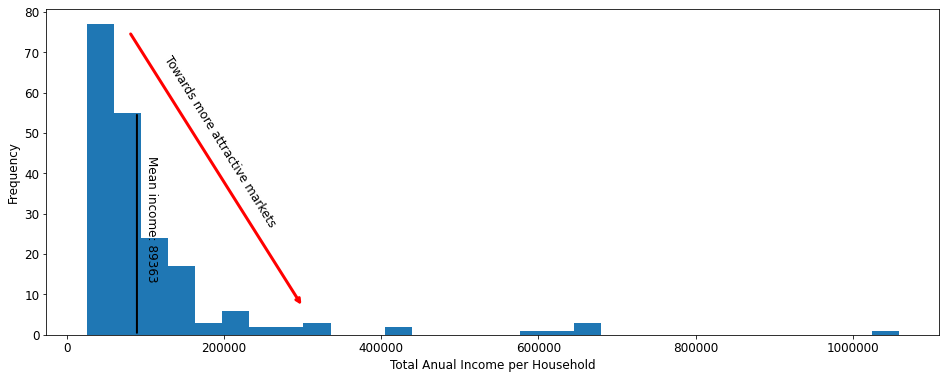

In [133]:
# Calculate the mean income for the Predicted_bilingual dataset:
total_income = Predicted_locations['Number of households']*Predicted_bilingual['Income per household']
mean_income = (total_income.sum())/Predicted_locations['Number of households'].sum()
print('The mean anual income per household is: '+str(int(mean_income)))
# Plot distribution of annual income per household and compare it against the mean income:
Predicted_bilingual['Income per household'].plot.hist(figsize=(16,6),bins=30)
plt.xlabel('Total Anual Income per Household',fontsize=12)
plt.ylabel('Frequency',fontsize=12)
plt.ticklabel_format(style='plain')
plt.tick_params(axis='both', which='major', labelsize=12)
plt.annotate('',xy=(mean_income,0),xytext=(mean_income,55),xycoords='data',arrowprops=dict(arrowstyle='-',connectionstyle='arc3',color='black',lw=2))
plt.annotate('',xy=(300000,7),xytext=(80000,75),xycoords='data',arrowprops=dict(arrowstyle='->',connectionstyle='arc3',color='red',lw=3))
plt.annotate('Towards more attractive markets',xy=(120000,26),xycoords='data',rotation=-58,va='bottom',ha='left',fontsize=12)
plt.annotate('Mean income: '+str(int(mean_income)),xy=(100000,13),xycoords='data',rotation=-90,va='bottom',ha='left',fontsize=12)
plt.show

__7.3.__ Calculate the mean available children capacity of childcare venues per number of dependants per zip code and compare it against our dataset:

The mean childcare capacity per dependant per zip code is: 0.071963


<function matplotlib.pyplot.show>

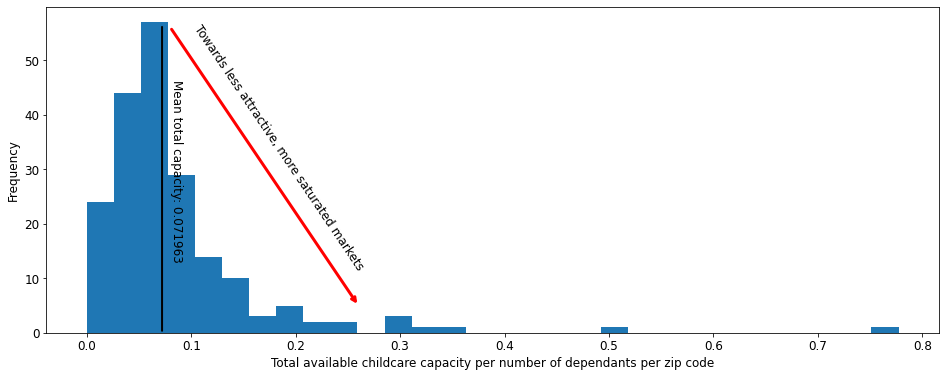

In [218]:
# Calculate the mean childcare capacity per dependant per zip code:
mean_tot_cap = Predicted_locations['TotalCapacity'].sum()/Predicted_locations['TotalDependants'].sum()
print('The mean childcare capacity per dependant per zip code is: '+str(round(mean_tot_cap,6)))
# Plot a histogram to analyze the distribution of TotalCap/Dependant:
Predicted_bilingual['TotalCap/Dependant'].plot.hist(figsize=(16,6),bins=30)
plt.xlabel('Total available childcare capacity per number of dependants per zip code',fontsize=12)
plt.ylabel('Frequency',fontsize=12)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.annotate('',xy=(mean_tot_cap,0),xytext=(mean_tot_cap,56.5),xycoords='data',arrowprops=dict(arrowstyle='-',connectionstyle='arc3',color='black',lw=2))
plt.annotate('',xy=(0.26,5),xytext=(0.08,56),xycoords='data',arrowprops=dict(arrowstyle='->',connectionstyle='arc3',color='red',lw=3))
plt.annotate('Towards less attractive, more saturated markets',xy=(0.10,11),xycoords='data',rotation=-56,va='bottom',ha='left',fontsize=12)
plt.annotate('Mean total capacity: '+str(round(mean_tot_cap,6)),xy=(0.08,13),xycoords='data',rotation=-90,va='bottom',ha='left',fontsize=12)
plt.show

__7.4.__ Calculate the mean available children capacity of __bilingual__ childcare venues per number of dependants per zip code and compare it against our dataset:

The mean bilingual childcare capacity per dependant per zip code is: 0.005301


<function matplotlib.pyplot.show>

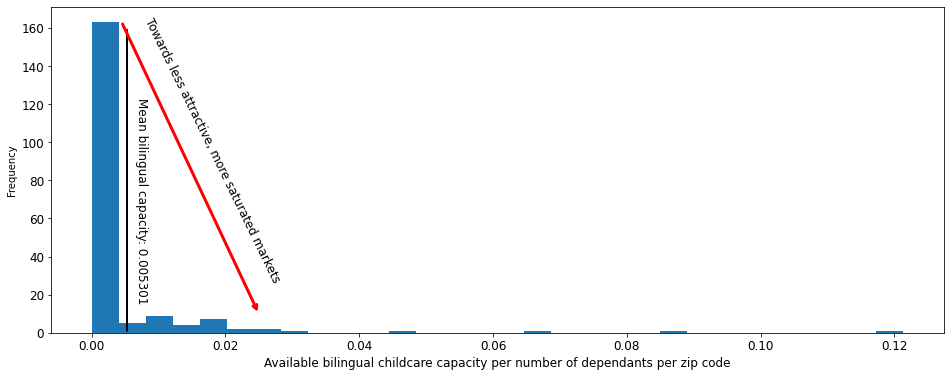

In [221]:
# Calculate the mean childcare capacity per dependant per zip code:
mean_bil_cap = Predicted_locations['BilingualCapacity'].sum()/Predicted_locations['TotalDependants'].sum()
print('The mean bilingual childcare capacity per dependant per zip code is: '+str(round(mean_bil_cap,6)))
# Plot a histogram to analyze the distribution of BilCap/Dependant:
Predicted_bilingual['BilCap/Dependant'].plot.hist(figsize=(16,6),bins=30)
plt.xlabel('Available bilingual childcare capacity per number of dependants per zip code',fontsize=12)
plt.ylabel('Frequency')
plt.tick_params(axis='both', which='major', labelsize=12)
plt.annotate('',xy=(mean_bil_cap,0),xytext=(mean_bil_cap,160),xycoords='data',arrowprops=dict(arrowstyle='-',connectionstyle='arc3',color='black',lw=2))
plt.annotate('',xy=(0.025,10),xytext=(0.0045,163),xycoords='data',arrowprops=dict(arrowstyle='->',connectionstyle='arc3',color='red',lw=3))
plt.annotate('Towards less attractive, more saturated markets',xy=(0.0075,25),xycoords='data',rotation=-64,va='bottom',ha='left',fontsize=12)
plt.annotate('Mean bilingual capacity: '+str(round(mean_bil_cap,6)),xy=(0.0065,15),xycoords='data',rotation=-90,va='bottom',ha='left',fontsize=12)
plt.show

Per conversations held with Company ABC, the company wants to focus on the following markets:
 - Zip codes where annual income per household is greater than 75% of the mean annual income.
 - Zip codes where total available childcare capacity per dependant is less than or equal to 150% of the mean.
 - Since the bilingual daycare market in Chicago is generally underserved, the threshhold for the available bilingual childcare capacity per dependant should be less than or equal to 0.02.

__7.5.__ Apply the defined threshholds to the dataset and filter down the results:

In [171]:
Predicted_final = Predicted_bilingual.drop(Predicted_bilingual[Predicted_bilingual['Income per household']<mean_income*.75].index).reset_index(drop=True)
Predicted_final = Predicted_final.drop(Predicted_final[Predicted_final['TotalCap/Dependant']>mean_tot_cap*1.5].index).reset_index(drop=True)
Predicted_final = Predicted_final.drop(Predicted_final[Predicted_final['BilCap/Dependant']>0.02].index).reset_index(drop=True)
# print top 10 locations:
print(Predicted_final.shape)
Predicted_final.head(10)

(72, 6)


,ZipCode,Income per household,TotalDependants,BilingualPredicted,BilCap/Dependant,TotalCap/Dependant
0,60618,87771.90,23740.0,1.485818,0.018787,0.103623
1,60007,75952.98,8930.0,0.934508,0.000000,0.017917
2,60076,84219.31,11100.0,0.785158,0.000000,0.075225
3,60515,131704.18,8420.0,0.779750,0.000000,0.063777
4,60077,70701.72,8190.0,0.775296,0.000000,0.096947
5,60148,78409.80,14000.0,0.699080,0.000000,0.055929
6,60068,151425.14,12100.0,0.604227,0.000000,0.051818
7,60655,87303.12,8680.0,0.600217,0.000000,0.007834
8,60606,580587.41,540.0,0.598937,0.000000,0.000000
9,60189,134025.58,8990.0,0.563421,0.000000,0.029922


From the table above, it looks like the best possible location for Company's ABC bilingual childcare center is zip code 60618. Let's take a closer look at the top 5 locations to make sure that zip code 60618 is indeed the best possible location.

### 8. Analyze the top 3 zip codes and recommend the best possible location:

__8.1.__ find out how many childcare locations already exist in each one of the top 5 zip codes:

In [187]:
df = Predicted_final.head(3)[['ZipCode']]
df = daycare_df.merge(df,how='right',right_on='ZipCode',left_on='Zip').reset_index(drop=True)
df = df.merge(IRS_df,how='left',right_on='Zip Code',left_on='Zip').reset_index(drop=True)
df = df.drop(columns=['ZipCode','Zip Code'])
df

,Zip,TotalCount,BilingualCount,TotalCapacity,BilingualCapacity,City,Number of households,Income per household,Dependants per household
0,60618,30,4,2460,446,Chicago,44160,87771.90,0.537591
1,60007,2,0,160,0,Elk Grove Village,18480,75952.98,0.483225
2,60076,12,0,835,0,Skokie,16830,84219.31,0.659537


__8.2.__ Visualize the top 3 locations on the map:

In [217]:
map_chicago2 = folium.Map(location=[41.98,-87.85], zoom_start=12)

df2 = df[['Zip']]
df2 = df2.merge(Chicago_df,how='left',left_on='Zip',right_on='Zip Code').reset_index(drop=True)

# add markers to map
for lat, lng, ZipCode, city in zip(df2['Latitude'], df2['Longitude'], df2['Zip Code'], df2['City']):
    label = '{}, {}'.format(city, ZipCode)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=10,
        popup=label,
        color='black',
        fill=True,
        fill_color='blue',
        fill_opacity=0.9,
        parse_html=False).add_to(map_chicago2)  
    
map_chicago2

__8.3.__ Analyze each zip code based on demographic information to make sure that hispanic/latin american markets exist in each one of the top zip codes, and evaluate the characteristics of each zip code separately:

 - __60618:__ There are a total of 30 childcare locations in this zip code, of which 4 are bilingual. By looking at the dataframe above, we can conclude that zip code 60618 has by far the largest population of the three, with more than 44k households and almost 24k claimed dependants. The total childcare capacity for this zip code is 2460, of which 446 are for bilingual childcare venues. Even though supply might seem high for bilingual childcares in this zip code, it is not really that high considering that __more than 40% of the population in this zip code are Hispanics and Latin Americans__, according to
<a href="https://www.illinois-demographics.com/60618-demographics">this website</a>. 60618 is also the 2nd most populated zip code in the state of Illinois. At 87,771 USD, zip code 60618 has the highest average annual income per household of the three.

 - __60007:__ There are just 2 childcare locations in this zip code, none of which are bilingual. Zip code 60007 (Elk Grove Village) is a residential area with a relatively high number of households and very low number of childcare venues. The total number of claimed dependants in this zip code is almost 9k, which makes the childcare capacity of just 160 look very low. The childcare market in this zip code is likely to be underserved, which could make it a great opportunity for starting a new childcare center in this zip code. However, only 11.8 % of people living in this zip code are hispanics or latinos, according to <a href="https://www.illinois-demographics.com/60007-demographics">this website</a>. Zip code 60007 has the lowest average annual income of the three at almost 76k USD per household.

 - __60076:__ Zip code 60076 has the fewest number of households of the three, but not the fewest number of claimed dependants. This zip code has a little more than 11k claimed dependants and a total childcare capacity of 835 children. There are no bilingual childcare venues in this zip code, which is consistent with it's low population of hispanics and latin americans, which according to <a href="https://www.illinois-demographics.com/60076-demographics">this website</a>, accounts for just 10.6% of its population, the lowest of the three. The average annual income per household in Zip code 60076 is slightly more than 84k USD.

__Final Recommendation:__ Since more than 40% of the population in zip code 60618 are hispanics and latin americans, and since there are almost 24 thousand claimed dependants in 60618, zip code 60618 is my recommended location for starting up a new bilingual childcare center. Even though competition could be thougher in this zip code than in the other two, the market in 60618 is substantially larger than in the other two zip codes, specially for a bilingual (English-Spanish) daycare. Moreover, zip code 60618 is located closer to the city center of Chicago than 60007 and 60076. In addition 60618 is located right in between Evanston and Chicago, which makes 60618 a good strategic location for offering bilingual childcare services for residents of Evanston who commute to Chicago for work and vice versa.